In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import pandas as pd
import sys
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns

sys.path.append("..")
from utils.load_las_data import normalize_z_with_minz_in_a_radius

from config import args
from utils.load_las_data import load_all_las_from_folder
import os
import numpy as np; np. set_printoptions(suppress=True);  # display values without scientific notation
import pandas as pd
from laspy.file import File
from sklearn.neighbors import NearestNeighbors
import warnings
import random

In [8]:
# define helper functions copied from base code

# load -> coordinates are in meter
def load_single_las(las_folder, las_file):
    # Parse LAS files
    las = File(os.path.join(las_folder, las_file), mode="r")
    x_las = las.X
    y_las = las.Y
    z_las = las.Z
    r = las.Red
    g = las.Green
    b = las.Blue
    nir = las.nir
    intensity = las.intensity
    return_nb = las.return_num
    points_placette = np.asarray(
        [x_las / 100, y_las / 100, z_las / 100, r, g, b, nir, intensity, return_nb]
    ).T  # we divide by 100 as all the values in las are in cm

    # There is a file with 2 points 60m above others (maybe birds), we delete these points
    if las_file == "Releve_Lidar_F70.las":
        points_placette = points_placette[points_placette[:, 2] < 640]
    # We do the same for the intensity
    if las_file == "POINT_OBS8.las":
        points_placette = points_placette[points_placette[:, -2] < 32768]
    if las_file == "Releve_Lidar_F39.las":
        points_placette = points_placette[points_placette[:, -2] < 20000]
    
    # Add a feature:min-normalized using min-z of the plot
    zmin_plot = np.min(points_placette[:, 2])
    points_placette = np.append(
        points_placette, points_placette[:, 2:3] - zmin_plot, axis=1
    )
        # get the average
    xy_averages = [
        np.mean(x_las) / 100,
        np.mean(y_las) / 100,
    ]
    return points_placette, xy_averages

In [9]:
def load_my_data():
    # load data
    las_folder = args.las_placettes_folder_path
    # We open las files and create a training dataset
    nparray_clouds_dict = {}  # dict to store numpy array with each plot separately
    xy_averages_dict = (
        {}
    )  # we keep track of plots means to reverse the normalisation in the future
    # We iterate through las files and transform them to np array
    las_files = os.listdir(las_folder)
    las_files = [l for l in las_files if l.lower().endswith(".las")]
    all_points_nparray = np.empty((0, args.nb_feats_for_train))
    for las_file in las_files:
        points_nparray, xy_averages = load_single_las(las_folder, las_file)
        all_points_nparray = np.append(all_points_nparray, points_nparray, axis=0)
        nparray_clouds_dict[os.path.splitext(las_file)[0]] = points_nparray
        xy_averages_dict[os.path.splitext(las_file)[0]] = xy_averages
    return nparray_clouds_dict

In [10]:
def select_my_clouds():
    # F49 = nparray_clouds_dict["Releve_Lidar_F49"][:,:3]
    # F68 = nparray_clouds_dict["Releve_Lidar_F68"][:,:3]  # Vm everywhere
    # OBS_2021_6 = nparray_clouds_dict["2021_POINT_OBS6"][:,:3]  # "hyper flag en termes de MNT"
    # F20 = nparray_clouds_dict["Releve_Lidar_F20"][:,:3]  # "hyper flag en termes de MNT"

    plots_of_interest = [
        "Releve_Lidar_F69",
        "2021_POINT_OBS9",  # grass 100%, high slope: 0-3m to 0-0.4cm slope with 1.5
        "Releve_Lidar_F49",  # loads of high vegetation. Ok with 1.5m
        "Releve_Lidar_F68",  # dense bushes. Ok with 1.5 : adds contrast.
        "2021_POINT_OBS6",  # 75% grass (subestimation of model). might add contrats linked to grass
        "Releve_Lidar_F20",  # 75% grass, 25% mid veg. ok,
        "2021_POINT_OBS59",
    ]
    # focus on medium veg
    plots_of_interest = plots_of_interest + []
    selection = {
        key: value
        for key, value in nparray_clouds_dict.items()
        if key in plots_of_interest
    }
    return selection

In [25]:
# %matplotlib notebook
def plot_norm_impact(cloud, cloud_norm, title, output_path):
    cloud[:,2] = cloud[:,2] - np.min(cloud[:,2])
    
    fig = plt.figure(figsize=plt.figaspect(0.8) * 2.5)
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    fig.suptitle(title)

    # without norm
    ax = fig.add_subplot(2, 2, 1, projection="3d")
    ax.scatter3D(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=cloud[:, 2] + 0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=0., azim=0)

    ax = fig.add_subplot(2, 2, 3)
    sns.distplot(cloud[:,2],ax=ax, kde=False)


    # with norm
    cloud_norm[:,2] = cloud_norm[:,2] - np.min(cloud_norm[:,2])
    ax = fig.add_subplot(2, 2, 2, projection="3d")
    ax.scatter3D(cloud_norm[:, 0], cloud_norm[:, 1], cloud_norm[:, 2], c=cloud_norm[:, 2] + 0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=0., azim=0)

    ax = fig.add_subplot(2, 2, 4)
    sns.distplot(cloud_norm[:,2],ax=ax, kde=False)

    plt.tight_layout()
    plt.savefig(output_path, dpi = 100, facecolor=fig.get_facecolor(), edgecolor='none')

### Fonctionnal code to integrate is here 

In [26]:
DIM_METERS = 20


def center_plot(cloud):
    """Center the cloud to 0, also return the initial xymin to decenter the cloud"""
    xy_min = cloud[:, :2].min(axis=0)
    cloud[:, :2] = cloud[:, :2] - xy_min - np.array([DIM_METERS // 2, DIM_METERS // 2])
    return cloud, xy_min


def decenter_plot(cloud, xy_min):
    cloud[:, :2] = cloud[:, :2] + xy_min + np.array([DIM_METERS // 2, DIM_METERS // 2])
    return cloud


def xy_to_polar_coordinates(xy):
    r = np.sqrt((xy * xy).sum(axis=1))
    teta = np.arctan2(
        xy[:, 1], xy[:, 0]
    )  # -pi, pi around (0,0) to (1,0). y and x are args in this order.
    rteta = np.stack([r, teta], axis=1)
    return rteta


def polar_coordinates_to_xy(rteta):
    x = rteta[:, 0] * np.cos(rteta[:, 1])
    y = rteta[:, 0] * np.sin(rteta[:, 1])
    xy = np.stack([x, y], axis=1)
    return xy


def create_buffer_points(cloud, ring_thickness_meters):
    """cloud is centered with xy as first coordinates in meters."""
    candidates_polar = cloud.copy()
    candidates_polar[:, :2] = xy_to_polar_coordinates(candidates_polar[:, :2])
    candidates_polar = candidates_polar[
        candidates_polar[:, 0] > (DIM_METERS // 2 - ring_thickness_meters)
    ]  # points in external ring
    candidates_polar[:, 1] = candidates_polar[:, 0] + 2 * (
        DIM_METERS // 2 - candidates_polar[:, 0]
    )  # use border of plot as a mirror
    candidates_polar[:, :2] = polar_coordinates_to_xy(candidates_polar[:, :2])
    return candidates_polar


# TRUE VERSION
# def normalize_z_with_smooth_spline(cloud, pix_size, ring_thickness_meters, s=None):
#     """From a regular grid, find lowest point in each cell/pixel and use them to approximate
#     the DTM with a spline. Then, normalize z by flattening the ground using the DTM.
#     """
#     norm_cloud = cloud.copy()

#     # center in order to use polar coordinate
#     norm_cloud, xy_min = center_plot(norm_cloud)

#     # create buffer
#     buffer_points = create_buffer_points(norm_cloud, ring_thickness_meters)
#     extended_cloud = np.concatenate([norm_cloud, buffer_points])

#     # fit
#     xy_quantified = (
#         extended_cloud[:, :2] // pix_size + 0.5
#     ) * pix_size  # quantify (and center) coordinates
#     xy_pairs, z_argmin = npi.group_by(xy_quantified).argmin(extended_cloud[:, 2])
#     sbs = SmoothBivariateSpline(
#         extended_cloud[z_argmin, 0],
#         extended_cloud[z_argmin, 1],
#         extended_cloud[z_argmin, 2],
#         kx=3,
#         ky=3,
#         s=s,
#     )

#     # predict on normcloud
#     norm_cloud[:, 2] = norm_cloud[:, 2] - sbs(
#         norm_cloud[:, 0], norm_cloud[:, 1], grid=False
#     )
#     # get back to initial coordinate system
#     norm_cloud = decenter_plot(norm_cloud, xy_min)
#     return norm_cloud

# DBEUG VERSION
def normalize_z_with_smooth_spline(cloud, pix_size, ring_thickness_meters, s=None):
    """From a regular grid, find lowest point in each cell/pixel and use them to approximate
    the DTM with a spline. Then, normalize z by flattening the ground using the DTM.
    """
    norm_cloud = cloud.copy()

    # center in order to use polar coordinate
    norm_cloud, xy_min = center_plot(norm_cloud)

    # create buffer
    buffer_points = create_buffer_points(norm_cloud, ring_thickness_meters)
    print(buffer_points.shape)
    norm_cloud = np.concatenate([norm_cloud, buffer_points])
    print(norm_cloud.shape)

    # fit
    xy_quantified = (
        norm_cloud[:, :2] // pix_size + 0.5
    ) * pix_size  # quantify (and center) coordinates
    _, z_argmin = npi.group_by(xy_quantified).argmin(norm_cloud[:, 2])
    sbs = SmoothBivariateSpline(
        norm_cloud[z_argmin, 0],
        norm_cloud[z_argmin, 1],
        norm_cloud[z_argmin, 2],
        kx=5,
        ky=5,
        s=s,
    )

    #     # predict on normcloud
    #     norm_cloud[:, 2] = norm_cloud[:, 2] - sbs(
    #         norm_cloud[:, 0], norm_cloud[:, 1], grid=False
    #     )
    # Plot the approximation
    norm_cloud[:, 2] = sbs(norm_cloud[:, 0], norm_cloud[:, 1], grid=False)
    # get back to initial coordinate system
    norm_cloud = decenter_plot(norm_cloud, xy_min)
    return norm_cloud

In [27]:
from scipy.interpolate import SmoothBivariateSpline
import numpy_indexed as npi

np.random.seed(0)
# fake data
xy = (
    np.random.random((1000, 2)) * DIM_METERS + 10000
)  # 20*20 and with an offset that needs to be removed


def fxy(x, y):
    return -np.sin(y * 2) + np.cos(x * 2) * 2 + 2 * np.cos(x) * np.sin(x * 2)


z = fxy(xy[:, 0:1], xy[:, 1:2])
xyz = np.append(xy, z, axis=1)


normalize_z_with_smooth_spline(xyz, 1.5, 8, s=None)

(969, 3)
(1969, 3)


array([[10010.97627008, 10014.30378733,    -1.09366857],
       [10012.05526752, 10010.89766366,    -0.38346708],
       [10008.47309599, 10012.91788226,    -2.19944384],
       ...,
       [10011.25242312, 10015.94796047,    -1.67401217],
       [10005.62566466, 10010.61319519,    -2.84707064],
       [10009.60540823, 10007.17240372,    -1.50727724]])

In [28]:
np.concatenate([xyz, xyz]).shape

(2000, 3)

# Try with real data

In [29]:
nparray_clouds_dict = load_my_data()
selection = select_my_clouds()

(4609, 10)
(9218, 10)
./temp_cloud_extension/extended_spline_pl_2021_POINT_OBS9_pix_size_1.50.png


<IPython.core.display.Javascript object>


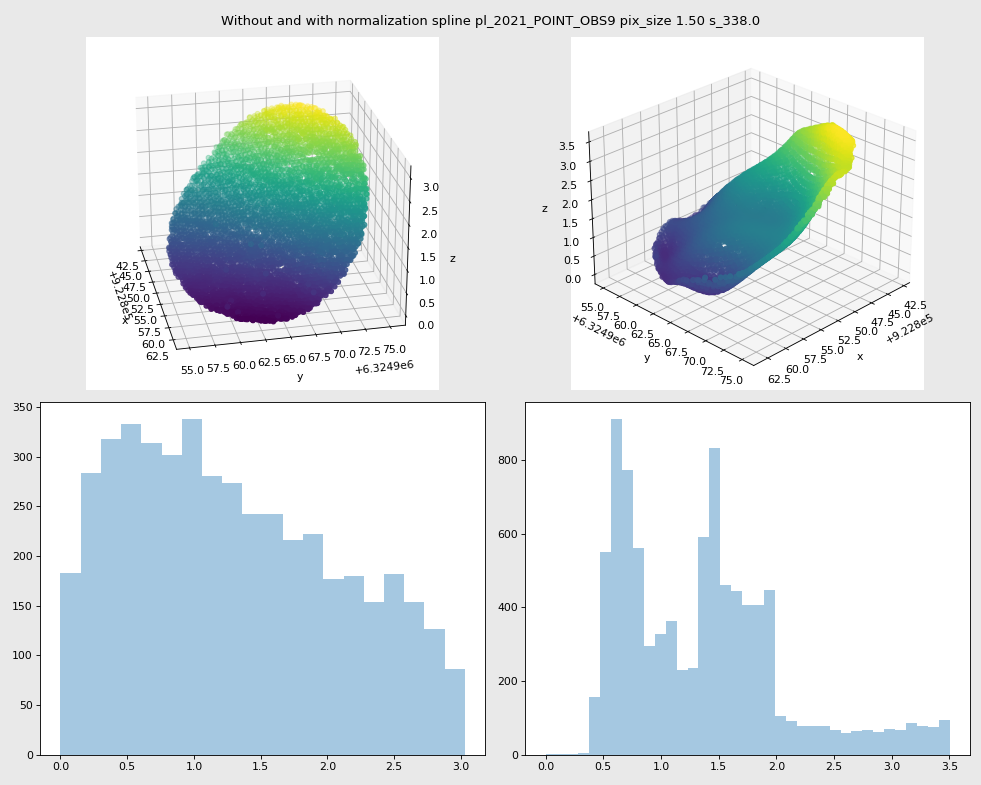

(5895, 10)
(11790, 10)
./temp_cloud_extension/extended_spline_pl_2021_POINT_OBS6_pix_size_1.50.png


<IPython.core.display.Javascript object>


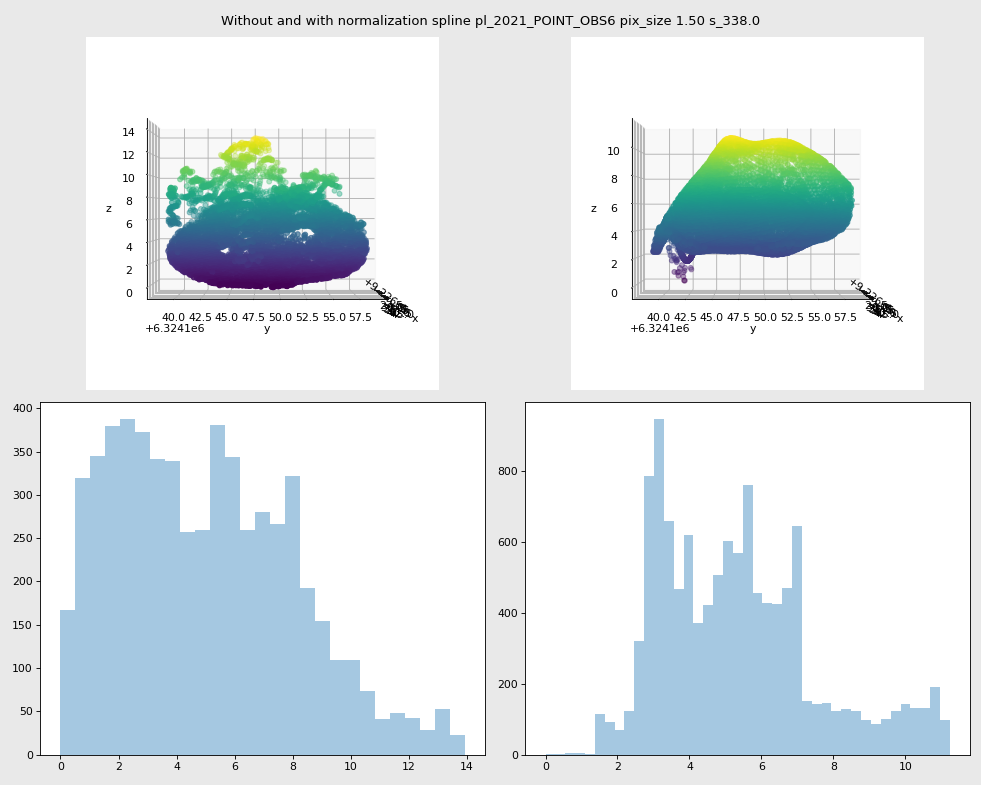

(4030, 10)
(8060, 10)
./temp_cloud_extension/extended_spline_pl_Releve_Lidar_F68_pix_size_1.50.png


<IPython.core.display.Javascript object>


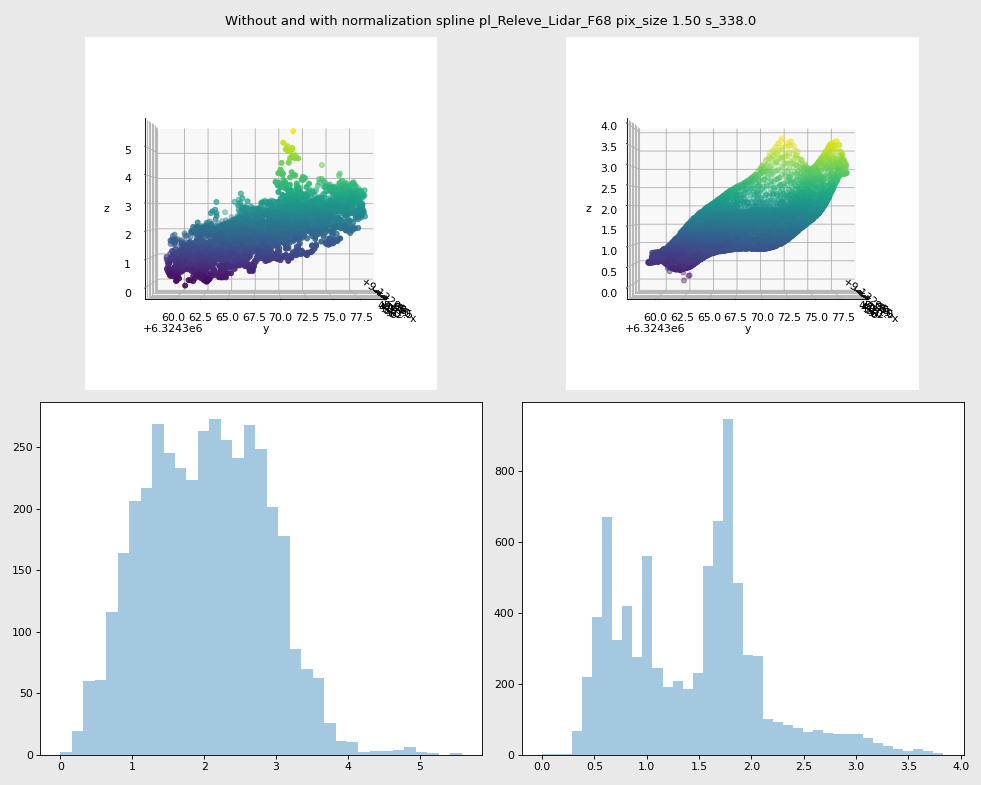

(3901, 10)
(7802, 10)
./temp_cloud_extension/extended_spline_pl_2021_POINT_OBS59_pix_size_1.50.png


<IPython.core.display.Javascript object>


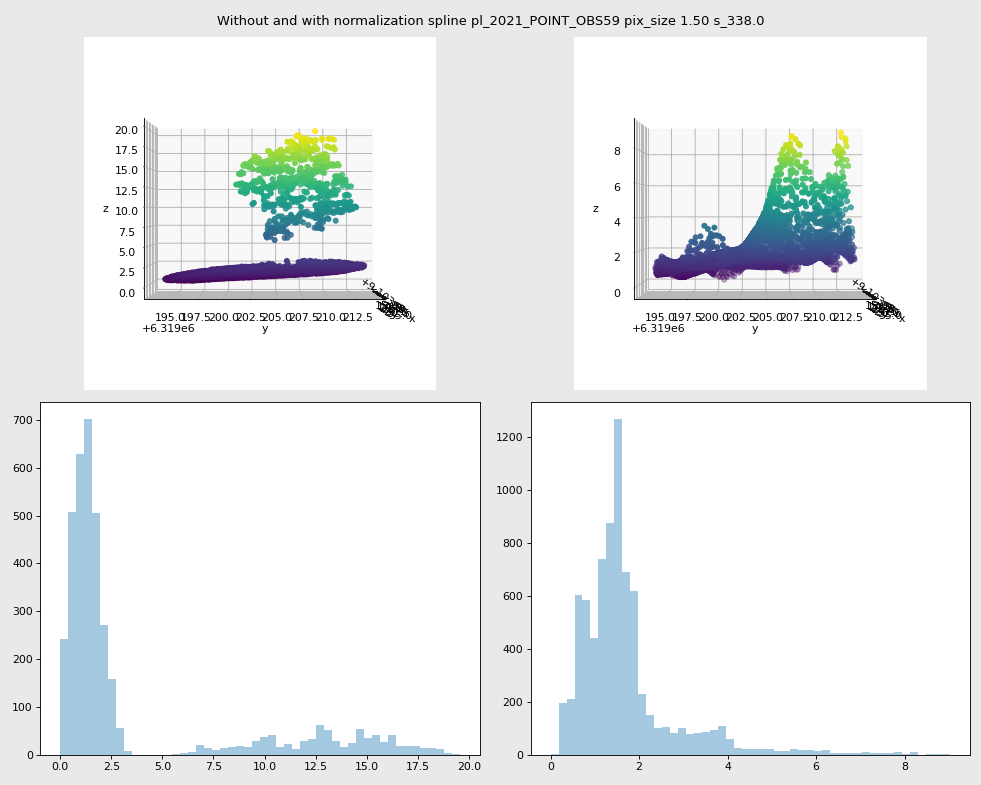

(7943, 10)
(15886, 10)
./temp_cloud_extension/extended_spline_pl_Releve_Lidar_F69_pix_size_1.50.png


<IPython.core.display.Javascript object>


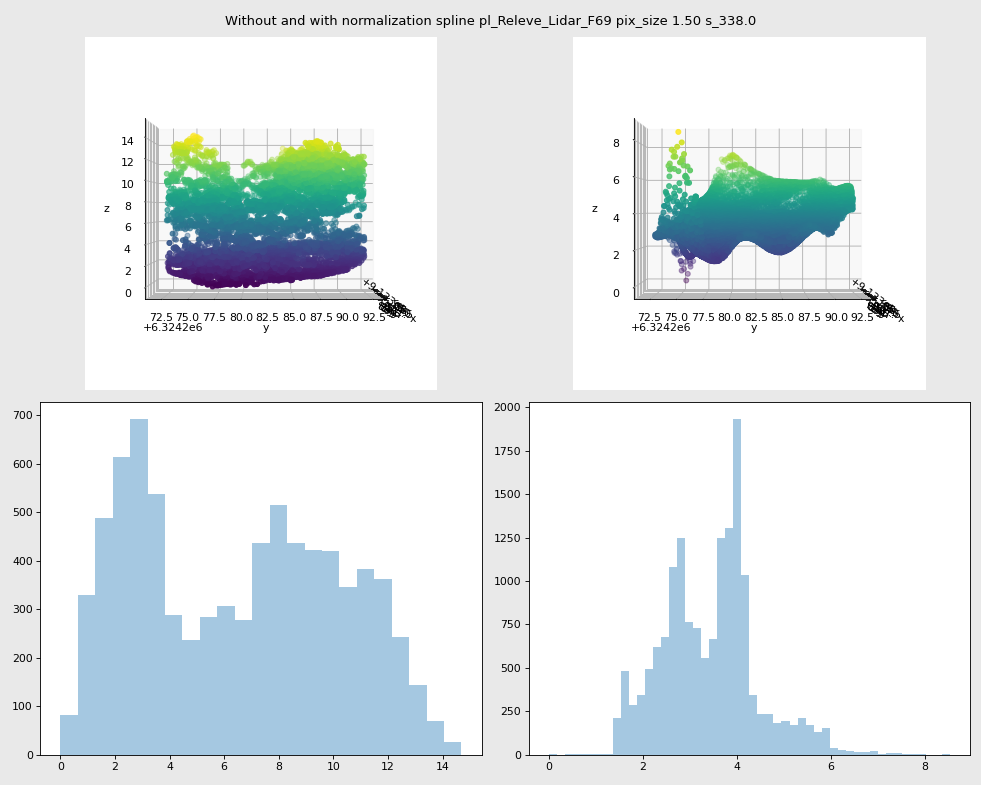

(7365, 10)
(14730, 10)
./temp_cloud_extension/extended_spline_pl_Releve_Lidar_F20_pix_size_1.50.png


<IPython.core.display.Javascript object>


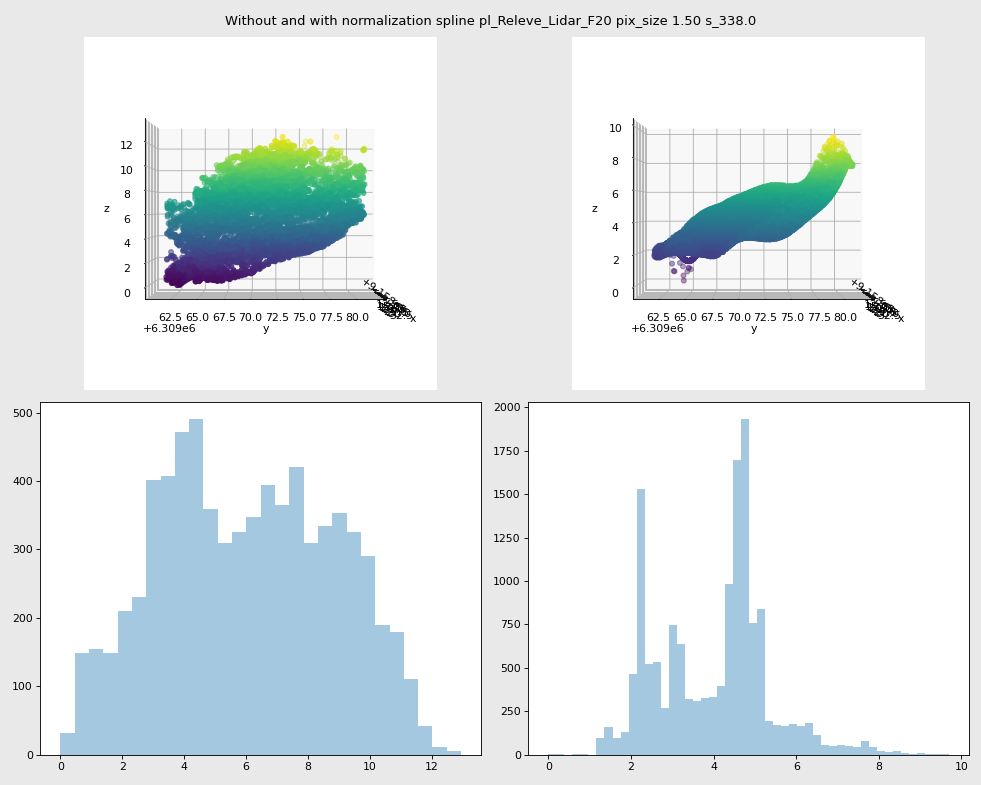

(8779, 10)
(17558, 10)
./temp_cloud_extension/extended_spline_pl_Releve_Lidar_F49_pix_size_1.50.png


<IPython.core.display.Javascript object>


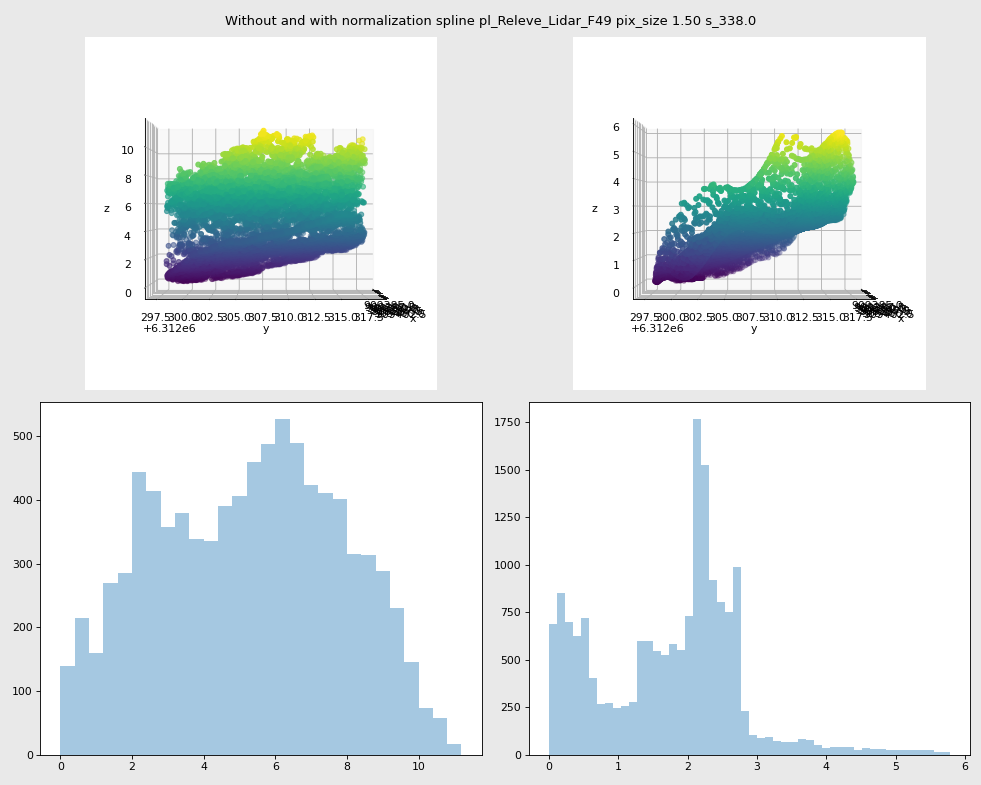

In [30]:
%matplotlib notebook
# range_pix_size = np.arange(0.5, 3, 0.25)
range_pix_size = [1.5]

for name, my_cloud in selection.items():
    for pix_size in range_pix_size:
        s = (20 // pix_size) ** 2 * 2
        cloud = my_cloud.copy()
        output_path = (
            f"./temp_cloud_extension/extended_spline_pl_{name}_pix_size_{pix_size:.02f}.png"
        )
        cloud_norm = normalize_z_with_smooth_spline(cloud, pix_size, 15, s=s)
        title = (
            f"Without and with normalization spline pl_{name} pix_size {pix_size:.02f} s_{s}"
        )
        print(output_path)
        plot_norm_impact(cloud, cloud_norm, title, output_path)

In [32]:
xy_to_polar_coordinates(my_cloud)

array([[6377550.91248085,       1.42771394],
       [6377739.17244961,       1.42771366],
       [6377567.23549173,       1.42771334],
       ...,
       [6377784.67767272,       1.42771328],
       [6377626.85339005,       1.42771342],
       [6377751.95487593,       1.42771334]])

In [24]:
cloud.shape

(8779, 10)